**How to organize data files:**

Should exist directory "data" with "train.csv", "train_boxes.csv" and "imgs" directory, which contains all 50000 images.

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from pylab import colorbar
import matplotlib.patches as patches
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 9)

import pandas as pd
import numpy as np

from tqdm import tqdm

from PIL import Image
from keras import backend as K
from keras.models import load_model

from ipywidgets import widgets
from IPython.display import display, clear_output

import random
random.seed(10113)

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

image_filename  lighting city
0  frame_20f328fa-2459-46d0-97a5-5ae2d6103cb0_000...  Twilight  NYC
1  frame_927bde20-f97f-48c2-af30-f9127b6b32ce_000...       Day  NYC
2  frame_67012509-f3bd-4175-a9d2-565a7b6bb3c7_000...       Day  NYC
3  frame_bd043377-6fb8-407a-95e5-7deb1fbab13a_000...       Day  NYC
4  frame_4da1583b-58d0-4893-8149-54541191031d_000...       Day  NYC

In [3]:
train_boxes = pd.read_csv('data/train_boxes.csv')
train_boxes.head()

image_filename          x0          y0  \
0  frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...  601.600000  270.355731   
1  frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...  497.777778  308.774704   
2  frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...  449.422222  310.197628   
3  frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...  711.111111  304.505929   
4  frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...  584.533333  307.351779   

           x1          y1 label  confidence  
0  726.755556  421.185771   van         1.0  
1  534.755556  338.656126   car         1.0  
2  509.155556  358.577075   car         1.0  
3  786.488889  368.537549   car         1.0  
4  647.111111  358.577075   car         1.0

Let's take a look at images.

In [4]:
def draw_image_num(num):
    filename = train.image_filename.values[num]

    fig,ax = plt.subplots(figsize=(16,9))
    ax.imshow(Image.open("data/imgs/" + filename))
    for _, row in train_boxes[train_boxes.image_filename == filename].iterrows():
        x0, x1, y0, y1 = row.x0, row.x1, row.y0, row.y1
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=4, edgecolor='w', facecolor='none')
        ax.add_patch(rect)
    _ = plt.title(train['city'].values[num] + " " + train['lighting'].values[num])

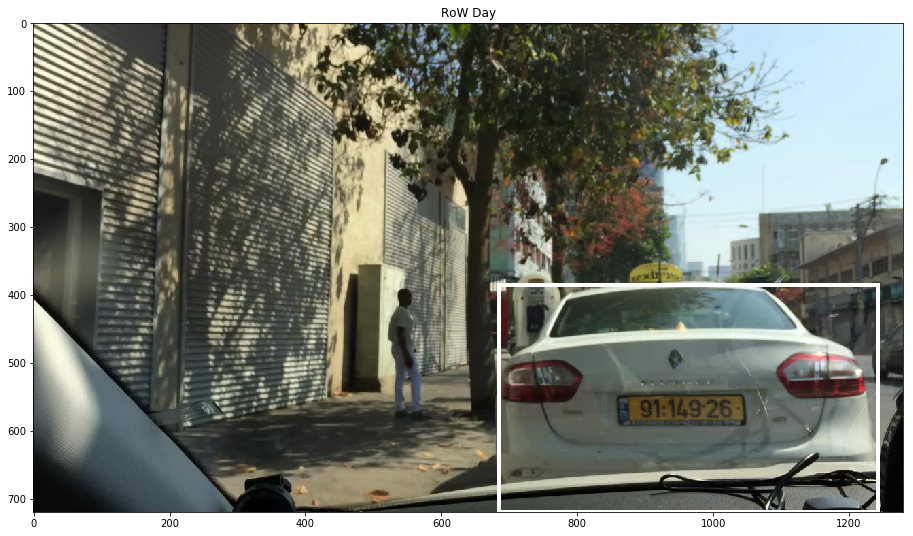

In [5]:
current_image_num = [20000]  # here start number can be chaged
count_images = train.shape[0]

def show_next_image(_):
    current_image_num[0] = (current_image_num[0] + 1) % count_images
    clear_output()
    status_text.value = str(current_image_num[0])
    draw_image_num(current_image_num[0])

def show_prev_image(_):
    current_image_num[0] = (current_image_num[0] - 1) % count_images
    clear_output()
    status_text.value = str(current_image_num[0])
    draw_image_num(current_image_num[0])

container = widgets.HBox()
button_next = widgets.Button(description='Next')
button_prev = widgets.Button(description='Prev')
status_text = widgets.Text()
container.children = [button_prev, status_text, button_next]
display(container)
button_next.on_click(show_next_image)
button_prev.on_click(show_prev_image)
status_text.value = str(current_image_num[0])
draw_image_num(current_image_num[0])

Sometimes, part of vehicles should be detected (image 37), sometimes not (image 24).

**Rectangle areas**

In [6]:
def get_area(row):
    return (row.x1 - row.x0) * (row.y1 - row.y0)

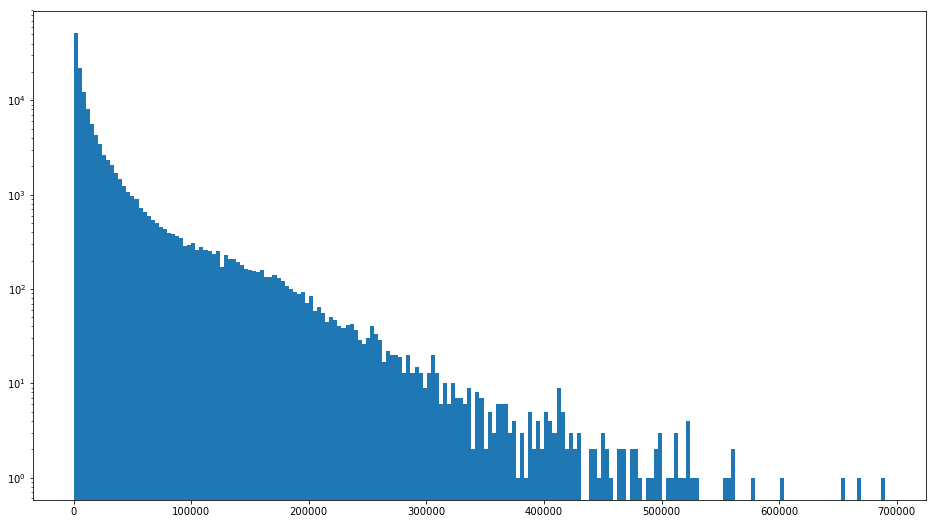

In [8]:
areas = (train_boxes.x1.values - train_boxes.x0.values) * (train_boxes.y1.values - train_boxes.y0.values)
_ = plt.hist(areas, bins=200, log=True)

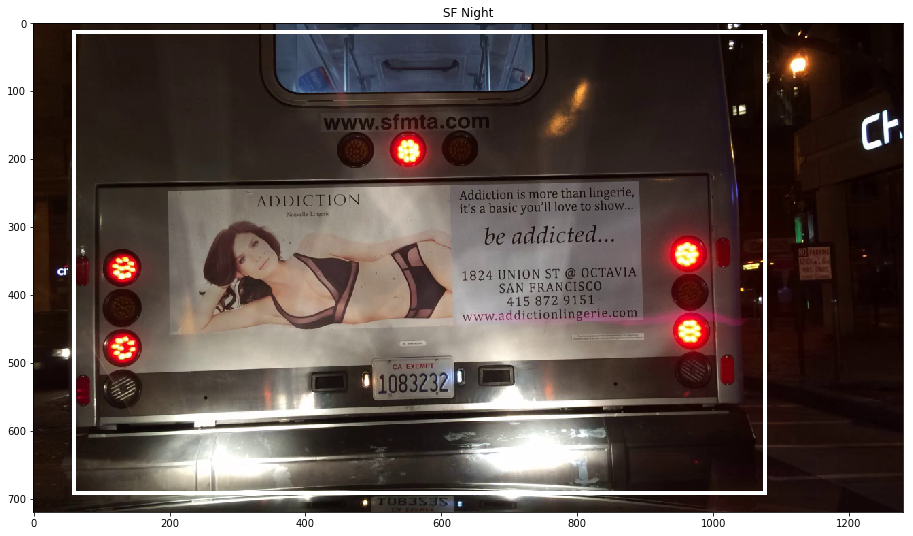

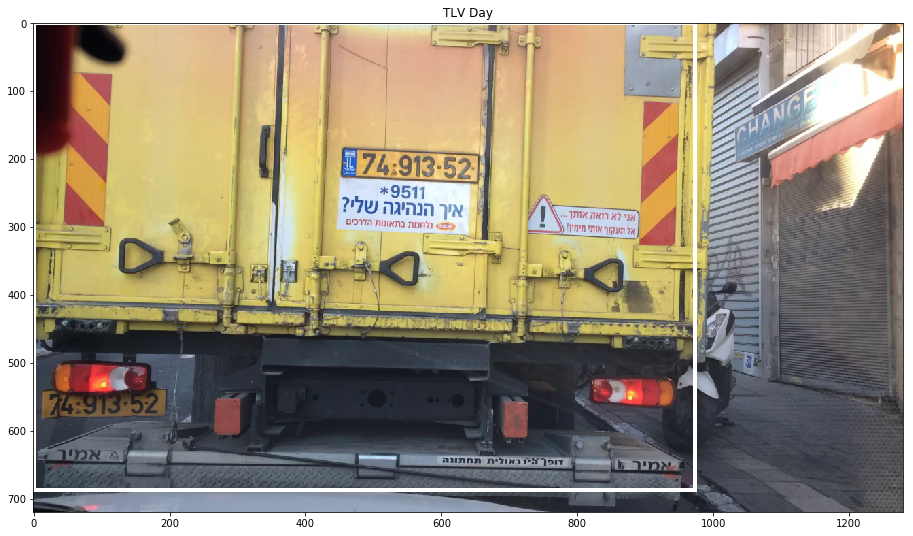

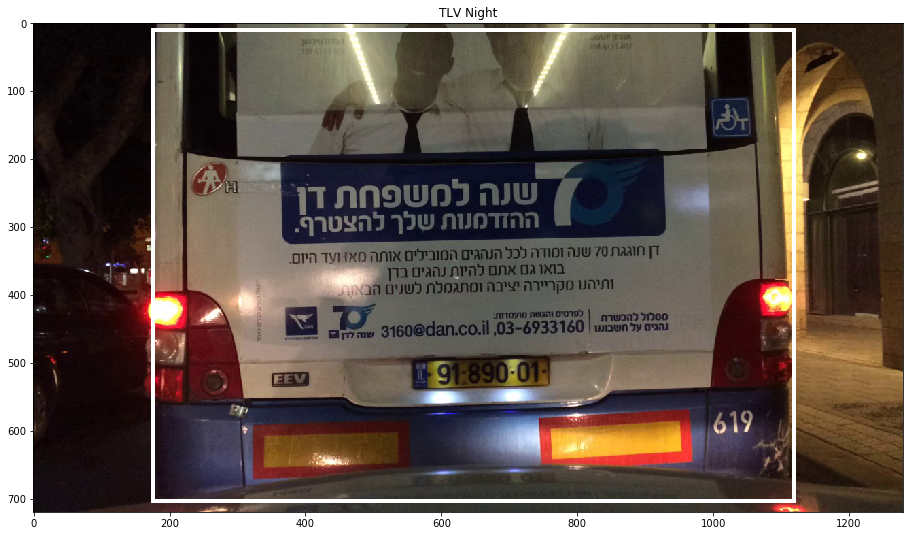

In [9]:
for i, area in enumerate(areas):
    if area > 650000:
        draw_image_num(train[train.image_filename == train_boxes.image_filename.values[i]].index.tolist()[0])

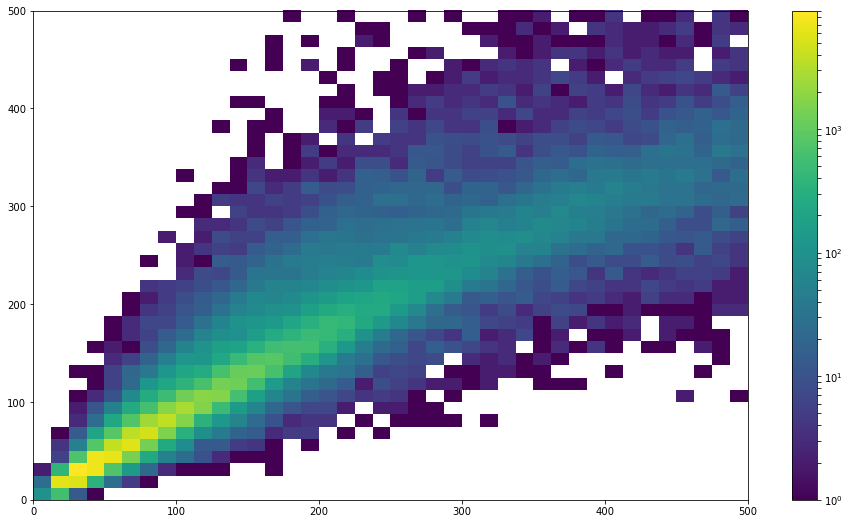

In [25]:
h = plt.hist2d(x=train_boxes.x1.values - train_boxes.x0.values, 
               y=train_boxes.y1.values - train_boxes.y0.values,
               bins=40,
               range=((0, 500), (0, 500)),
               norm=LogNorm(),)
_ = colorbar(h[3])

**YOLO approach**

Let's try to detect with YOLO, trained with ImageNet (just download weights). 

YOLO is written with Darknet framework, it's not convenient to use it from Python.

I use https://github.com/allanzelener/YAD2K project to convert Darknet model to Keras model.

!!WARNING Error is possible "TypeError: float() argument must be a string or a number, not 'dict'"

In case of this error you need download source code of Keras, fix this error (https://github.com/fchollet/keras/issues/7107#issuecomment-310632271) and setup it manually (python setup.py install).

In [26]:
!git clone https://github.com/allanzelener/yad2k.git

Cloning into 'yad2k'...
remote: Counting objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 2.35 MiB | 476.00 KiB/s, done.
Resolving deltas: 100% (106/106), done.
Checking connectivity... done.


In [28]:
# download darknet weights
!wget http://pjreddie.com/media/files/yolo.weights -O yad2k/yolo.weights

--2017-08-11 11:35:29--  http://pjreddie.com/media/files/yolo.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/yolo.weights [following]
--2017-08-11 11:35:30--  https://pjreddie.com/media/files/yolo.weights
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yad2k/yolo.weights’

100%[======================================>] 203,934,260 1.07MB/s   in 3m 20s 

2017-08-11 11:38:52 (993 KB/s) - ‘yad2k/yolo.weights’ saved [203934260/203934260]



In [29]:
# download darknet config
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolo.cfg -O yad2k/yolo.cfg

--2017-08-11 11:38:57--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolo.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.84.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.84.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2726 (2.7K) [text/plain]
Saving to: ‘yad2k/yolo.cfg’

100%[======================================>] 2,726       --.-K/s   in 0s      

2017-08-11 11:38:58 (20.3 MB/s) - ‘yad2k/yolo.cfg’ saved [2726/2726]



In [30]:
#convert Darknet weights to Keras weights
!./yad2k/yad2k.py yad2k/yolo.cfg yad2k/yolo.weights yad2k/yolo.h5

Using TensorFlow backend.
Loading weights.
Weights Header:  [       0        1        0 32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
2017-08-11 11:40:09.153768: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-11 11:40:09.153828: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-11 11:40:09.153853: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-08-11 11:40:09.153860: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library 

Saved Keras model to yad2k/yolo.h5
Read 50983561 of 50983561.0 from Darknet weights.


In [10]:
from yad2k.yad2k.models.keras_yolo import yolo_eval, yolo_head

anchors_path = 'yad2k/yolo_anchors.txt'
classes_path = 'yad2k/model_data/coco_classes.txt'
score_threshold = 0.3
iou_threshold = 0.5

yolo_model = load_model('yad2k/yolo.h5')

with open(classes_path) as f:
    class_names = [line.strip() for line in f.readlines()]
with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=score_threshold,
    iou_threshold=iou_threshold)

/home/bendyna/anaconda2/envs/ds3/lib/python3.6/site-packages/Keras-2.0.6-py3.6.egg/keras/models.py:247: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [11]:
def get_predictions(image_filenames):
    result = []
    for image_file in tqdm(image_filenames):
        image = Image.open('data/imgs/' + image_file)
        resized_image = image.resize((608, 608), Image.BICUBIC)
        image_data = np.array(resized_image, dtype='float32')

        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)

        out_boxes, out_scores, out_classes = K.get_session().run(
            [boxes, scores, classes],
            feed_dict={
                yolo_model.input: image_data,
                input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        prediction_boxes = []
        for i in range(len(out_boxes)):
            if class_names[out_classes[i]] in {'car', 'bus', 'truck'}:
                box = (out_boxes[i][1], out_boxes[i][0], out_boxes[i][3], out_boxes[i][2])
                prediction_boxes.append((out_scores[i], box))
        true_boxes = []
        for _, row in train_boxes[train_boxes.image_filename == image_file].iterrows():
            true_boxes.append((row.x0, row.y0, row.x1, row.y1))
        result.append((image_file, true_boxes, prediction_boxes))
    return result

In [12]:
# each element in arr (image_filename, true_boxes, prediction_boxes)
# each prediction box (score, box)
def draw_image_with_boxes(arr):
    for image_file, true_boxes, prediction_boxes in arr:
        fig, ax = plt.subplots()
        ax.imshow(Image.open('data/imgs/' + image_file))
        for left, top, right, bottom in true_boxes:
            rect = patches.Rectangle((left, top), right - left, bottom - top, linewidth=4, 
                                     edgecolor='w', facecolor='none')
            ax.add_patch(rect)
        for score, (left, top, right, bottom) in prediction_boxes:
            rect = patches.Rectangle((left, top), right - left, bottom - top, linewidth=2, 
                                     edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()

100%|██████████| 5/5 [00:13<00:00,  2.81s/it]


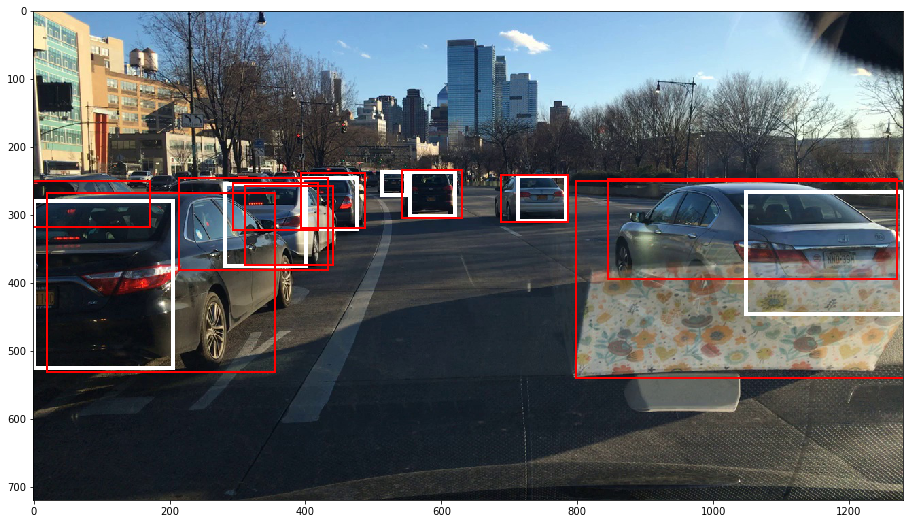

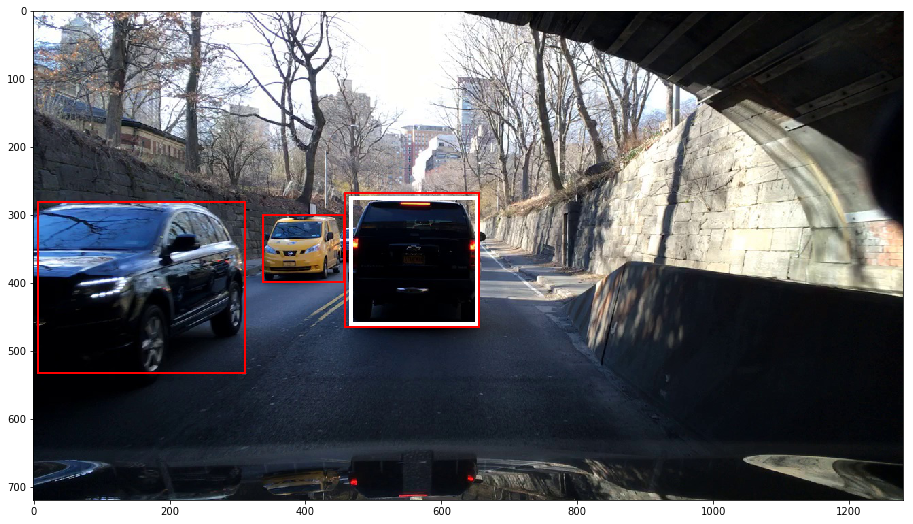

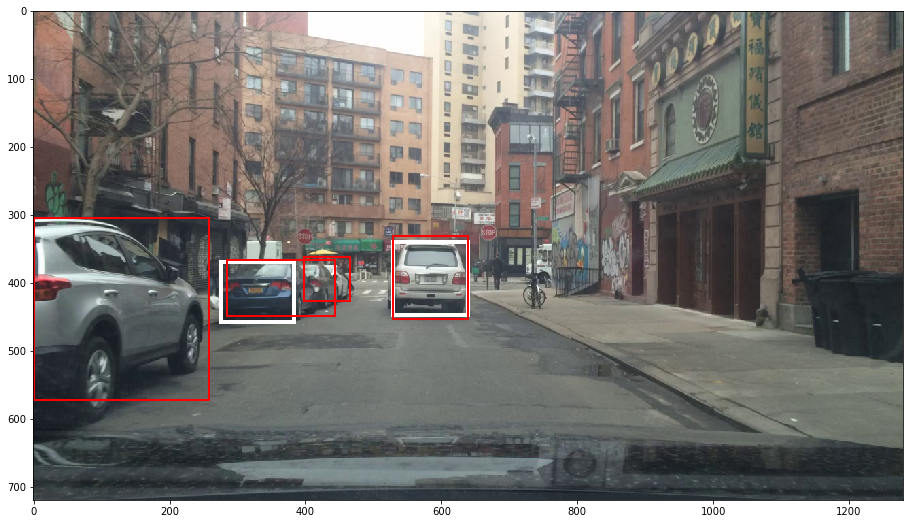

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


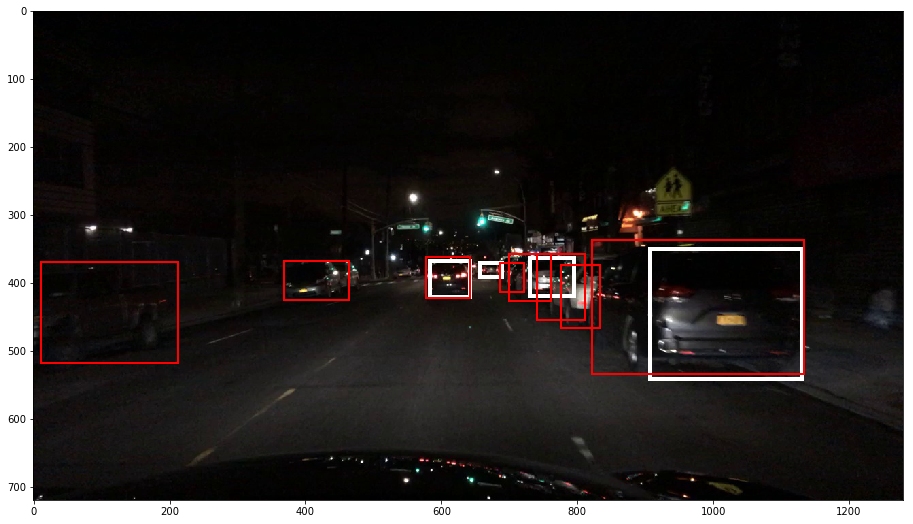

In [39]:
draw_image_with_boxes(get_predictions(train.image_filename.values[2000:2005]))

We can see that YOLO model is quite good, but it detects full car and we need only back side of car in this task. Also it detects cars, which move in opposite direction.

Anyway, let's calculate AP of this YOLO model.

In [13]:
# box - (xmin, ymin, xmax, ymax)
def IOU(box1, box2):
    left = max(box1[0], box2[0])
    top = max(box1[1], box2[1])
    right = min(box1[2], box2[2])
    bottom = min(box1[3], box2[3])
    w = max(0, right - left + 1)
    h = max(0, bottom - top + 1)
    inter = w * h
    uni = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1) \
            + (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1) - inter
    return inter * 1. / uni

In [20]:
# each element in arr (image_filename, true_boxes, prediction_boxes)
# each prediction box (score, box)
def average_precision(arr, iou_threshold=0.75):
    score_detection = []
    all_true = 0
    for _, true_boxes, prediction_boxes in arr:
        all_true += len(true_boxes)
        detected = [0] * len(true_boxes)
        pboxes = sorted(prediction_boxes, key=lambda x: x[0], reverse=True)
        for score, box in pboxes:
            best = None
            best_iou = 0
            for i in range(len(true_boxes)):
                if detected[i]:
                    continue
                iou = IOU(true_boxes[i], box)
                if iou >= iou_threshold and iou > best_iou:
                    best, best_iou = i, iou
            if best is not None:
                detected[i] = 1
                score_detection.append((score, 1))
            else:
                score_detection.append((score, 0))
    score_detection = sorted(score_detection, key=lambda x: x[0], reverse=True)
    result = 0
    width = 1. / all_true
    height = 1
    count = 0
    count1 = 0
    for score, detection in score_detection:
        count += 1
        if detection:
            result += width * height
            count1 += 1
        else:
            height = count1 * 1.0 / count
    return result

In [18]:
average_precision(get_predictions(random.sample(list(train.image_filename.values), 1000)))

100%|██████████| 1000/1000 [46:36<00:00,  2.73s/it] 


0.037589127809364284

Let's try calculate score with other threshold.

In [21]:
average_precision(get_predictions(random.sample(list(train.image_filename.values), 1000)), iou_threshold=0.5)

100%|██████████| 1000/1000 [46:00<00:00,  2.88s/it]


0.26255212566504604

Changing threshold from 0.75 to 0.5 gives score improvement 0.03 -> 0.26!! So, algorithm detect cars quite good but  predicted boxes are not very precise.

Usual IOU threshold for detection is 0.5, but in this problem it is 0.75 and algorithm should detect cars very accurately.

Links for next research:

https://github.com/allanzelener/YAD2K Keras YOLOv2

https://arxiv.org/abs/1612.08242 YOLOv2 paper

https://www.youtube.com/watch?v=_GfPYLNQank CS231n about detection

https://medium.com/towards-data-science/how-to-train-your-own-object-detector-with-tensorflows-object-detector-api-bec72ecfe1d9